# Annotation from prompt with Grounding Dino, followed by SAM segmentation

#### Course:Deep Neural Engineering (IM1102)
#### Group: Ellen Cordemans, Ilse Harmers & Sem Pepels

The code in this notebook is partially based on the documentation on Hugging Face 
https://github.com/huggingface/transformers/blob/main/docs/source/en/model_doc/grounding-dino.md

A font file is downloaded from https://fonts.gstatic.com/s/roboto/v30/KFOlCnqEu92Fr1MmEU9vAw.ttf

---

In [1]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from torchvision import io, utils
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from ultralytics import SAM
from pathlib import Path
from autodistill.utils import plot
from roboflow import Roboflow
import h5py
import numpy as np
import supervision as sv
import cv2

directory structure

```
+ Y:/ai/projects/IM1102
  + run1
  + ds/grounding_dino_sam
    + full
        data.yaml
        *.jpg
        *.txt
    + full_output
```

In [2]:
project_root =     Path("Y:/ai/projects/IM1102")
yrun_dir =         Path("Y:/ai/projects/IM1102/run1")
dataset_dir =      Path("Y:/ai/projects/IM1102/ds/grounding_dino_sam")
dataset_in_dir =   Path(project_root/"ds/grounding_dino_sam/full")
dataset_out_dir =  Path(project_root/"ds/grounding_dino_sam/full_output")


In [3]:
textlabels = [["0", "door", "front yard", "window"]]
class2name = {'0':'0', '1':'door', '2':'front yard', '3':'window'}
name2class = {v: k for k, v in class2name.items()}


The first model in the pipeline is ``IDEA-Research/grounding-dino-base``

In [4]:
#model1_id = "IDEA-Research/grounding-dino-tiny"
model1_id = "IDEA-Research/grounding-dino-base"
device = "cpu"
processor = AutoProcessor.from_pretrained(model1_id)
model1 = AutoModelForZeroShotObjectDetection.from_pretrained(model1_id).to(device)

def run_model1(imgfn):
    image = Image.open(imgfn)
    inputs = processor(images=image, text=textlabels, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model1(**inputs)
    results = processor.post_process_grounded_object_detection(
        outputs, inputs.input_ids, threshold=0.4, text_threshold=0.3, target_sizes=[image.size[::-1]])
    result = results[0]
    result['clsid'] = []
    for textlabel in result['text_labels']:
        result['clsid'].append(int(name2class[textlabel]))
    return result

In [5]:
def packpolygons(arrofpoly):
    xs = [0]
    ys = []
    for elemofpoly in arrofpoly:
        xstot = xs[-1] + len(elemofpoly)
        xs.append(xstot)
        ys.extend(elemofpoly)
    return xs, ys

def unpackpolygons(xs, ys):
    toret = []
    for idx in range(len(xs)-1):
        toret.append(ys[ xs[idx] : xs[idx+1] ])
    return toret

In [12]:
aop = [[[1,1]], [[2,2],[3,3]], [[4,4],[5,5],[6,6]], [[7,7],[8,8],[9,9],[10,10]]]
xs,ys = packpolygons(aop)
print(xs)
print(ys)
aop2 = unpackpolygons(xs, ys)
print(aop2)

[0, 1, 3, 6, 10]
[[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]]
[[[1, 1]], [[2, 2], [3, 3]], [[4, 4], [5, 5], [6, 6]], [[7, 7], [8, 8], [9, 9], [10, 10]]]


In [6]:
model2 = SAM("mobile_sam.pt")

def run_model2(imgfn, bboxes):
    results = model2(imgfn, bboxes=bboxes, project="mobile_sam", save=True, save_txt=True)
    result = results[0]
    poly_index, poly_points = packpolygons(result.masks.xy)
    return(result, poly_index, poly_points)

In [7]:
model3 = SAM("sam2_b.pt")

def run_model3(imgfn, bboxes):
    results = model3(imgfn, bboxes=bboxes, project="sam2_b", save=True, save_txt=True)
    result = results[0]
    poly_index, poly_points = packpolygons(result.masks.xy)
    return(result, poly_index, poly_points)

In [15]:
r1 = run_model1(str(dataset_dir/'full/42132455_415_1440x960.jpg'))

In [30]:
#print(r1)
#print(r1['boxes'].numpy())
#print(r1['text_labels'])
#print(np.array(r1['clsid']))
#print(r1['scores'].numpy())

In [17]:
r2, poly_index2, poly_points2 = run_model2(str(dataset_dir/'full/42132455_415_1440x960.jpg'), r1['boxes'])


image 1/1 Y:\ai\projects\IM1102\ds\grounding_dino_sam\full\42132455_415_1440x960.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 2965.1ms
Speed: 41.3ms preprocess, 2965.1ms inference, 156.3ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to mobile_sam\predict8
1 label saved to mobile_sam\predict8\labels


In [36]:
#print(r2.boxes.xyxy)
#print(r2.boxes.xyxy.numpy())
#print(r2.boxes.conf.numpy())
#print(r2.masks)
#print(r2.masks.data.numpy())
#print(poly_index2)
#print(poly_points2)
#print(r2.masks.xy)


In [19]:
r3, poly_index3, poly_points3 = run_model3(str(dataset_dir/'full/42132455_415_1440x960.jpg'), r1['boxes'])


image 1/1 Y:\ai\projects\IM1102\ds\grounding_dino_sam\full\42132455_415_1440x960.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 9285.8ms
Speed: 29.2ms preprocess, 9285.8ms inference, 140.6ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to sam2_b\predict3
1 label saved to sam2_b\predict3\labels


In [32]:
#print(r3.boxes.xyxy)

In [21]:
with h5py.File(dataset_dir/'full_output/42132455_415_1440x960.hdf5', 'w') as f:
    f.create_dataset("base.boxes",             data=np.array(r1['boxes']))
    f.create_dataset("base.clsid",             data=np.array(r1['clsid']))
    f.create_dataset("base.scores",            data=np.array(r1['scores']))
    f.create_dataset("mobile_sam.boxes.xyxy",  data=np.array(r2.boxes.xyxy))
    f.create_dataset("mobile_sam.boxes.conf",  data=np.array(r2.boxes.conf))
    f.create_dataset("mobile_sam.masks.data",  data=torch.squeeze(r2.masks.data).numpy())
    f.create_dataset("mobile_sam.poly_index",  data=np.array(poly_index2))
    f.create_dataset("mobile_sam.poly_points", data=np.array(poly_points2))
    f.create_dataset("sam2_b.boxes.xyxy",      data=np.array(r3.boxes.xyxy))
    f.create_dataset("sam2_b.boxes.conf",      data=np.array(r3.boxes.conf))
    f.create_dataset("sam2_b.masks.data",      data=torch.squeeze(r3.masks.data).numpy())
    f.create_dataset("sam2_b.poly_index",      data=np.array(poly_index3))
    f.create_dataset("sam2_b.poly_points",     data=np.array(poly_points3))


In [22]:
with h5py.File(dataset_dir/'full_output/42132455_415_1440x960.hdf5', 'r') as f:
    y2 = sv.Detections(
        xyxy=np.array(f['mobile_sam.boxes.xyxy']), 
        mask=np.array(f['mobile_sam.masks.data']), 
        confidence=np.array(f['mobile_sam.boxes.conf']), 
        class_id=np.array(f['base.clsid']))
    y3 = sv.Detections(
        xyxy=np.array(f['sam2_b.boxes.xyxy']), 
        mask=np.array(f['sam2_b.masks.data']), 
        confidence=np.array(f['sam2_b.boxes.conf']), 
        class_id=np.array(f['base.clsid']))


In [33]:
#print(y2.xyxy)
#print(y2.class_id)

#### POC - mobile_sam result

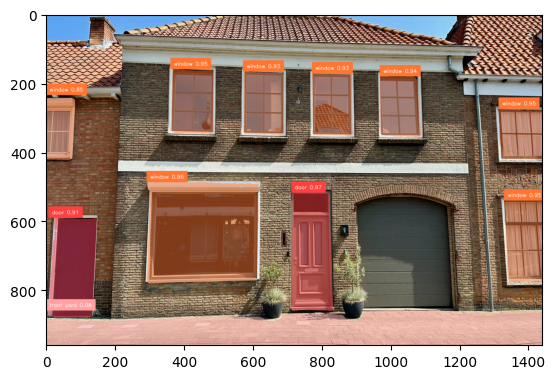

In [34]:
image=cv2.imread(str(dataset_dir/"full/42132455_415_1440x960.jpg"))
annotated_frame = plot(image=image, classes=textlabels[0], detections=y2, raw=True)
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))

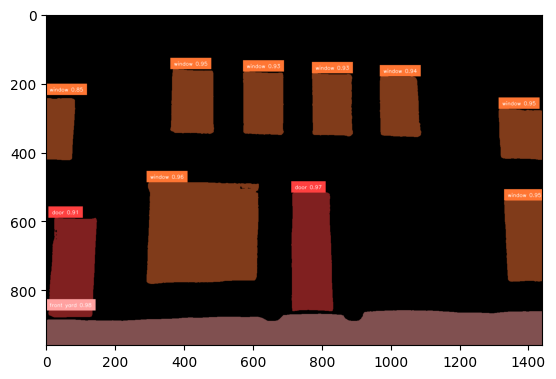

In [35]:
image2=np.uint8(np.zeros(annotated_frame.shape))
annotated_frame2 = plot(image=image2, classes=textlabels[0], detections=y2, raw=True )
plt.imshow(cv2.cvtColor(annotated_frame2, cv2.COLOR_BGR2RGB))

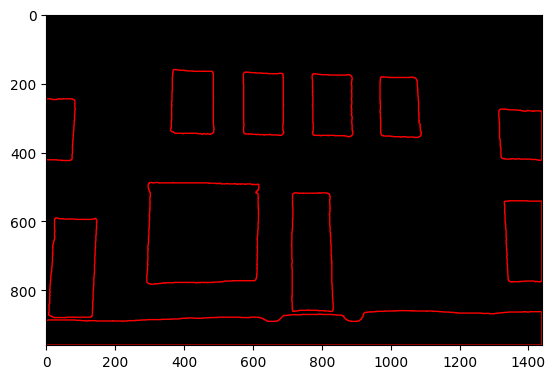

In [40]:
image3=np.uint8(np.zeros(annotated_frame.shape))
aop = unpackpolygons(poly_index2, poly_points2)
fig, ax = plt.subplots() 
ax.imshow(image3)
for xys in aop:
    poly = patches.Polygon(xys, linewidth=1, edgecolor='r', facecolor='none')  
    ax.add_patch(poly)
plt.show()

#### POC - sam2_b result

(960, 1440, 3)


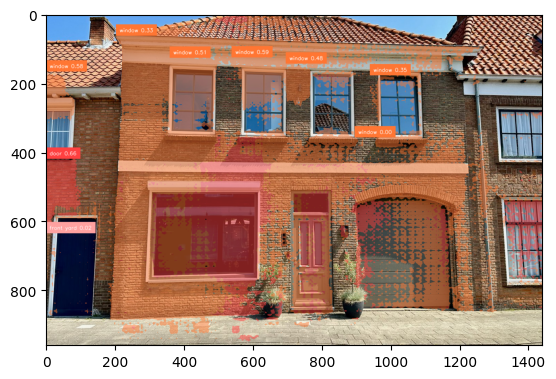

In [27]:
image=cv2.imread(str(dataset_dir/"full/42132455_415_1440x960.jpg"))
annotated_frame = plot(image=image, classes=textlabels[0], detections=y3, raw=True)
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))

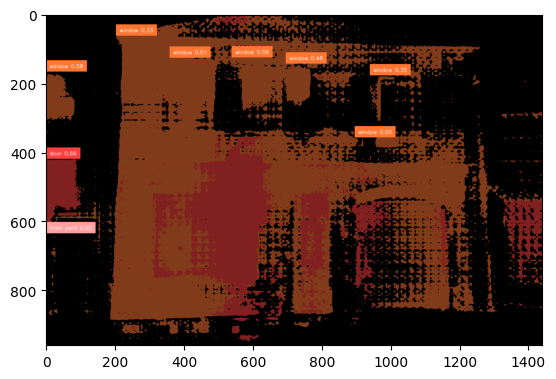

In [28]:
image2=np.uint8(np.zeros(annotated_frame.shape))
annotated_frame2 = plot(image=image2, classes=textlabels[0], detections=y3, raw=True )
plt.imshow(cv2.cvtColor(annotated_frame2, cv2.COLOR_BGR2RGB))

In [19]:
def run_model(imgfn, lblfn, outimgfn):
    image = Image.open(imgfn)
    w, h = image.size
    textlabels = [["0", "door", "front yard", "window"]]
    class2name = {'0':'0', '1':'door', '2':'front yard', '3':'window'}
    name2class = {v: k for k, v in class2name.items()}
    inputs = processor(images=image, text=textlabels, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(
        outputs, inputs.input_ids, threshold=0.4, text_threshold=0.3, target_sizes=[image.size[::-1]])
    result = results[0]
    result["colors"] = []
    result["lines"]  = []
    for box, labels in zip(result["boxes"], result["text_labels"]):
        if   labels == 'door':        color='green'
        elif labels == 'window':      color='red'
        elif labels == 'front yard':  color='blue'
        else:                         color='black'
        result["colors"].append(color)
        [x1, y1, x2, y2] = box
        ixywh = [ 
            name2class[labels], 
            "{:.6f}".format( (x1 + ((x2-x1)/2))/w ), 
            "{:.6f}".format( (y1 + ((y2-y1)/2))/h ), 
            "{:.6f}".format( (x2-x1)/w ), 
            "{:.6f}".format( (y2-y1)/h ) 
        ]
        result["lines"].append(' '.join(ixywh))
    lblfn.write_text("\n".join(sorted(result["lines"])))
    viz = utils.draw_bounding_boxes(F.pil_to_tensor(image), boxes=result['boxes'], labels=result['text_labels'], 
                                    font='KFOlCnqEu92Fr1MmEU9vAw.ttf', font_size=25, colors=result['colors'], width=4)
    imgo = F.to_pil_image(viz)
    imgo.save(outimgfn)
    #print(result)
    return imgfn, lblfn

### Run experiment - full scale

In [8]:
def run_and_save(imgfn, hdf5fn):
    r1 = run_model1(imgfn)
    r2, poly_index2, poly_points2 = run_model2(imgfn, r1['boxes'])
    r3, poly_index3, poly_points3 = run_model3(imgfn, r1['boxes'])
    with h5py.File(hdf5fn, 'w') as f:
        f.create_dataset("base.boxes",             data=np.array(r1['boxes']))
        f.create_dataset("base.clsid",             data=np.array(r1['clsid']))
        f.create_dataset("base.scores",            data=np.array(r1['scores']))
        f.create_dataset("mobile_sam.boxes.xyxy",  data=np.array(r2.boxes.xyxy))
        f.create_dataset("mobile_sam.boxes.conf",  data=np.array(r2.boxes.conf))
        f.create_dataset("mobile_sam.masks.data",  data=torch.squeeze(r2.masks.data).numpy())
        f.create_dataset("mobile_sam.poly_index",  data=np.array(poly_index2))
        f.create_dataset("mobile_sam.poly_points", data=np.array(poly_points2))
        f.create_dataset("sam2_b.boxes.xyxy",      data=np.array(r3.boxes.xyxy))
        f.create_dataset("sam2_b.boxes.conf",      data=np.array(r3.boxes.conf))
        f.create_dataset("sam2_b.masks.data",      data=torch.squeeze(r3.masks.data).numpy())
        f.create_dataset("sam2_b.poly_index",      data=np.array(poly_index3))
        f.create_dataset("sam2_b.poly_points",     data=np.array(poly_points3))

In [9]:
flist = sorted(Path(dataset_in_dir).glob('*.jpg'))
for imgfn in flist[]:
    hdf5fn = dataset_out_dir/ (imgfn.stem+'.hdf5')
    run_and_save(imgfn, hdf5fn)


image 1/1 Y:\ai\projects\IM1102\ds\grounding_dino_sam\full\43829840_964_1440x960.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 2604.3ms
Speed: 46.9ms preprocess, 2604.3ms inference, 130.8ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to mobile_sam\predict37
1 label saved to mobile_sam\predict37\labels

image 1/1 Y:\ai\projects\IM1102\ds\grounding_dino_sam\full\43829840_964_1440x960.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 8563.2ms
Speed: 15.7ms preprocess, 8563.2ms inference, 140.6ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to sam2_b\predict32
1 label saved to sam2_b\predict32\labels

image 1/1 Y:\ai\projects\IM1102\ds\grounding_dino_sam\full\43855272_140_1440x960.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 2606.3ms
Speed: 31.2ms preprocess, 2606.3ms inference, 78.1ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to mobile_sam\predict38
1 label saved to mo

### Evaluate experiment - full scale

In [12]:
def plot_annot(hdf5fn, imgfn, imgo2fn, mask2fn, imgo3fn, mask3fn):
    with h5py.File(hdf5fn, 'r') as f:
        y2 = sv.Detections(
            xyxy=np.array(f['mobile_sam.boxes.xyxy']), 
            mask=np.array(f['mobile_sam.masks.data']), 
            confidence=np.array(f['mobile_sam.boxes.conf']), 
            class_id=np.array(f['base.clsid']))
        y3 = sv.Detections(
            xyxy=np.array(f['sam2_b.boxes.xyxy']), 
            mask=np.array(f['sam2_b.masks.data']), 
            confidence=np.array(f['sam2_b.boxes.conf']), 
            class_id=np.array(f['base.clsid']))
    annotated_frame21 = plot(image=cv2.imread(imgfn), classes=textlabels[0], detections=y2, raw=True)
    plt.imsave(imgo2fn, cv2.cvtColor(annotated_frame21, cv2.COLOR_BGR2RGB))
    annotated_frame22 = plot(image=np.uint8(np.zeros(annotated_frame21.shape)), classes=textlabels[0], detections=y2, raw=True)
    plt.imsave(mask2fn, cv2.cvtColor(annotated_frame22, cv2.COLOR_BGR2RGB))
    annotated_frame31 = plot(image=cv2.imread(imgfn), classes=textlabels[0], detections=y3, raw=True)
    plt.imsave(imgo3fn, cv2.cvtColor(annotated_frame31, cv2.COLOR_BGR2RGB))
    annotated_frame32 = plot(image=np.uint8(np.zeros(annotated_frame21.shape)), classes=textlabels[0], detections=y3, raw=True)
    plt.imsave(mask3fn, cv2.cvtColor(annotated_frame32, cv2.COLOR_BGR2RGB))


In [14]:
flist = sorted(Path(dataset_out_dir).glob('*.hdf5'))
for hdf5fn in flist[]:
    imgfn   = dataset_in_dir/ (hdf5fn.stem+'.jpg')
    imgo2fn = dataset_out_dir/ (hdf5fn.stem+'2.jpg')
    mask2fn = dataset_out_dir/ (hdf5fn.stem+'2_m.jpg')
    imgo3fn = dataset_out_dir/ (hdf5fn.stem+'3.jpg')
    mask3fn = dataset_out_dir/ (hdf5fn.stem+'3_m.jpg')
    plot_annot(hdf5fn, imgfn, imgo2fn, mask2fn, imgo3fn, mask3fn)